# Explore overlap between Neanderthal-introgressed SNPs and Fairfax eQTLs
This code explores if any Neanderthal-introgressed SNPs (present in Chen introgressed sequences) are present in the list of monocyte extreme response peak eQTLs identified by Fairfax et al. Fisher's exact test and bootstrap test were performed to detect enrichment.

Neanderthal SNPs from:
1. Dannemann M, Prufer K & Kelso J. Functional implications of Neandertal introgression in modern humans. *Genome Biol* 2017 **18**:61.
2. Simonti CN *et al*. The phenotypic legacy of admixture between modern humans and Neandertals. *Science* 2016 **351**:737-41.

Neanderthal-introgressed sequences by Chen *et al.* from:
* Chen L *et al.* Identifying and interpreting apparent Neanderthal ancestry in African individuals. *Cell* 2020 **180**:677-687.  

Monocyte extreme response peak eQTLs from:
1. Fairfax BP *et al*. Innate immune activity conditions the effect of regulatory variants upon monocyte gene expression. *Science* 2014 **343**:1246949.

In [1]:
# Import libraries
import pandas as pd
import scipy.stats as stats
from random import sample
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

### Create dataframe containing SNPs in both Neanderthal and Fairfax datasets

In [2]:
# Load Chen Neanderthal SNPs
chen = pd.read_excel('../chen/Additional File 1.xlsx', 'Sheet1', usecols=['Chromosome', 'Position', 'Source', 'Chen'])
comparison_df = chen.loc[chen.Chen == 'Yes'].copy()
comparison_df['Source'] = comparison_df['Source'].astype('string')
comparison_df.drop('Chen', axis=1)

,Chromosome,Position,Source
0,1,834360,simonti_only
1,1,838695,simonti_only
2,1,850373,simonti_only
3,1,854793,simonti_only
13,1,1964852,simonti_only
...,...,...,...
353190,22,51020584,dannemann_only
353191,22,51026458,dannemann_only
353192,22,51026842,dannemann_only
353193,22,51028027,dannemann_only


In [3]:
# Load eQTL data
extr_resp = pd.read_csv("tab2_a_cis_eSNPs.txt", sep="\t", usecols=["SNP", "Gene", "SNP.Chrm", "SNP.pos", "Min.dataset"])
extr_resp = extr_resp.rename(columns={"SNP.Chrm": "Chromosome", "SNP.pos": "Position", "SNP": "ID"})
extr_resp = extr_resp.groupby(["Chromosome", "Position", "ID"]).agg(','.join).reset_index()

In [4]:
# Merge dataframes
extr_resp_df = comparison_df.merge(extr_resp, how='left', on=['Chromosome', 'Position'])
extr_resp_df = extr_resp_df.dropna()
extr_resp_df.head()

,Chromosome,Position,Source,Chen,ID,Gene,Min.dataset
3126,1,21636746,both,Yes,rs12756690,ECE1,LPS2
4595,1,37962756,dannemann_only,Yes,rs7544462,MEAF6,IFN
4824,1,40145850,both,Yes,rs17560858,LOC728448,IFN
5104,1,41309459,dannemann_only,Yes,rs12563360,ZNF684,LPS24
5151,1,41488722,both,Yes,rs11209368,CTPS,IFN


In [5]:
# Number of overlapping SNPs
len(extr_resp_df)

100

In [6]:
# Expression context
extr_resp_df['Min.dataset'].str.split(',', expand=True).stack().value_counts()

IFN      41
LPS24    31
Naive    25
LPS2     25
dtype: int64

In [7]:
# Genes associated with overlapped eQTLs
extr_resp_df['Gene'].str.split(',', expand=True).stack().value_counts()

NFATC1      3
OAS1        3
PCBD1       2
DCTD        2
UPF2        2
           ..
CAST        1
GJA3        1
HS.40289    1
CTHRC1      1
RAB3IP      1
Length: 107, dtype: int64

In [8]:
# African population MAFs
allpop_df = pd.read_csv("../neanderthal/allpop_fixed.csv")
extr_resp_df = extr_resp_df.merge(allpop_df, how='left', on=['Chromosome', 'Position', 'ID', 'Source'])
extr_resp_df[['ESN', 'YRI', 'MSL', 'GWD', 'LWK']].describe()

,ESN,YRI,MSL,GWD,LWK
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.001768,0.000747,0.001929,0.003364,0.004818
std,0.005947,0.004355,0.006214,0.007495,0.010251
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.004000,0.005000
max,0.045000,0.032000,0.047000,0.044000,0.056000


---

## Check for enrichment of Neanderthal SNPs in Fairfax eQTLs

### Fisher's exact test

In [9]:
# Number of Chen Neanderthal SNPs in all genotyped Fairfax SNPs
all_genotyped_snps = pd.read_csv("extreme_response/extreme_response.bim", sep="\t", header=None)
all_genotyped_snps.drop(2, axis=1, inplace=True)
all_genotyped_snps = all_genotyped_snps.rename(columns={0: "Chromosome", 1: "ID", 3: "Position",
                                                        4: "Major", 5: "Minor"})
merged = comparison_df.merge(all_genotyped_snps, how="left", on=["Chromosome", "Position"])
merged = merged.dropna()
len(merged)

2836

In [10]:
stats.fisher_exact([[100, 18911], [2736, 592338]])

(1.1448247423062972, 0.19176486125653208)

### Bootstrap test

In [11]:
# All genotyped SNPs from Fairfax
exre = open('bootstrap/extreme_response.txt', 'r').read().splitlines()

In [12]:
#Chen Neanderthal SNPs
nSNP = []
for chrom, pos in zip(comparison_df['Chromosome'], comparison_df['Position']):
    nSNP.append(str(chrom) + ' ' + str(pos))
chen_exre = set(nSNP).intersection(exre)

In [13]:
# Fairfax eQTLs 
eSNP = []
for chrom,pos in zip(extr_resp['Chromosome'], extr_resp['Position']):
    eSNP.append(str(chrom) + ' ' + str(pos))
eSNP_exre = set(eSNP).intersection(exre)

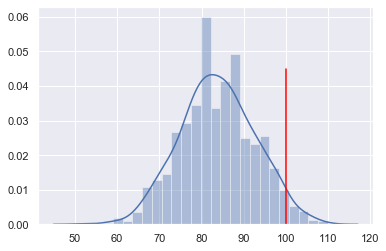

In [14]:
# Bootstrap
results = []
for i in range(1000):
    results.append(len(set(sample(exre, len(chen_exre))).intersection(eSNP_exre)))
sns.distplot(results)
plt.plot([100, 100], [0, 0.045], color='red')
plt.show()

In [15]:
count = 0
for x in results:
    if x > 100:
        count += 1
print(count)

26


---

## Check for enrichment of Neanderthal SNPs in IFN-specific vs LPS-specific eQTLs

### Fisher's exact test

In [16]:
# Number of Fairfax eQTLs that are IFN-specific or LPS-specific
IFN_count = 0
LPS_count = 0
eqtl_ifn = []
eqtl = []
for index, row in extr_resp.iterrows():
    if 'IFN' in row['Min.dataset'] and 'LPS' not in row['Min.dataset']:
        IFN_count += 1
        eqtl_ifn.append(row['ID'])
        eqtl.append(row['ID'])
    elif 'IFN' not in row['Min.dataset'] and 'LPS' in row['Min.dataset']:
        LPS_count += 1
        eqtl.append(row['ID'])
print('IFN: ' + str(IFN_count) + ', LPS: ' + str(LPS_count))

IFN: 5270, LPS: 8923


In [17]:
# Number of Neanderthal-introgressed, Fairfax eQTLs that are IFN-specific or LPS-specific
IFN_count = 0
LPS_count = 0
nean_eqtl = []
for index, row in extr_resp_df.iterrows():
    if 'IFN' in row['Min.dataset'] and 'LPS' not in row['Min.dataset']:
        IFN_count += 1
        nean_eqtl.append(row['ID'])
    elif 'IFN' not in row['Min.dataset'] and 'LPS' in row['Min.dataset']:
        LPS_count += 1
        nean_eqtl.append(row['ID'])
print('IFN: ' + str(IFN_count) + ', LPS: ' + str(LPS_count))

IFN: 32, LPS: 46


In [18]:
stats.fisher_exact([[32, 5238], [46, 8877]])

(1.1789431744608796, 0.4824333566863386)

### Bootstrap test

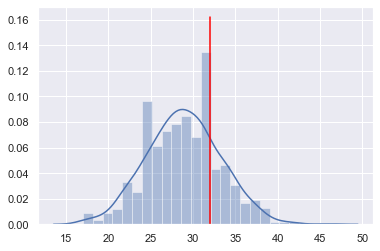

In [19]:
bootstrap = []
for i in range(1000):
    bootstrap.append(len(set(sample(eqtl, len(nean_eqtl))).intersection(eqtl_ifn)))
sns.distplot(bootstrap)
plt.plot([32, 32], [0, 0.162], color='red', label='34')
plt.show()

In [20]:
count = 0
for x in bootstrap:
    if x > 32:
        count += 1
print(count)

203
